In [1]:
# 安裝
!pip install yfinance > log.txt
!pip install Backtesting==0.2.0 > log.txt
!pip install talib-binary

In [2]:
import yfinance as yf
import pandas as pd

def get_historical_data(ticker):
  d = yf.Ticker(ticker)
  df = d.history(period="5y")
  df.columns = df.columns.str.lower()
  df.columns = pd.Series(df.columns).str.capitalize().values
  return df.dropna()

df = get_historical_data('BTC-USD')
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2017-01-29,922.067017,923.418030,919.148010,919.495972,60851700,0,0
2017-01-30,920.151001,923.047974,919.473999,920.382019,78227296,0,0
2017-01-31,920.958984,972.018982,920.958984,970.403015,164582000,0,0
2017-02-01,970.940979,989.114014,970.742004,989.023010,150110000,0,0
2017-02-02,990.000977,1013.520020,983.221008,1011.799988,145820992,0,0


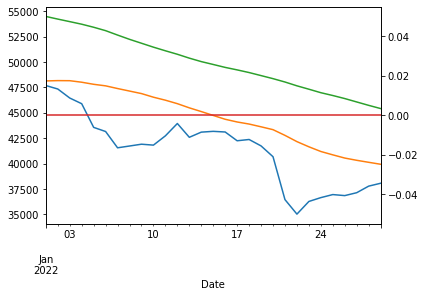

In [5]:
import talib

# compute simple moving average using talib
sma1 = talib.SMA(df.Close, timeperiod=20)
sma2 = talib.SMA(df.Close, timeperiod=60)

# compute buy and sell signals (golden cross and death cross)
signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

# combine long and short signals
signal = signal_long.copy()
signal[signal_short] = -1

# plot
df.Close['2022'].plot()
sma1['2022'].plot()
sma2['2022'].plot()
signal['2022'].astype(int).plot(secondary_y=True)

In [6]:
from backtesting import Backtest, Strategy

class Strategy(Strategy):
    
    n1 = 20
    n2 = 60
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        sma1 = talib.SMA(close, timeperiod=self.n1)
        sma2 = talib.SMA(close, timeperiod=self.n2)

        # Precompute signal
        signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
        signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot sma
        self.I(lambda x: sma1, 'sma1')
        self.I(lambda x: sma2, 'sma2')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]

        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
          for trade in self.trades:
              trade.close()

bt = Backtest(df, Strategy)
result1 = bt.run()
bt.plot()

/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:44: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [7]:
#輸入回測的條件，df是資料，初始資金10000，交易成本0.2%
bt = Backtest(df, Strategy, cash=10000, commission=0.002)

#將跑完回測得到的數據放到stats
stats = bt.run()
stats

Start                     2017-01-29 00:00:00
End                       2022-01-29 00:00:00
Duration                   1826 days 00:00:00
Exposure Time [%]                      53.202
Equity Final [$]                       309633
Equity Peak [$]                        379098
Return [%]                            2996.33
Buy & Hold Return [%]                 4040.11
Max. Drawdown [%]                     -68.249
Avg. Drawdown [%]                    -9.08786
Max. Drawdown Duration      557 days 00:00:00
Avg. Drawdown Duration       38 days 00:00:00
# Trades                                   15
Win Rate [%]                          53.3333
Best Trade [%]                        397.599
Worst Trade [%]                      -23.5082
Avg. Trade [%]                         26.697
Max. Trade Duration         197 days 00:00:00
Avg. Trade Duration          64 days 00:00:00
Profit Factor                         9.99019
Expectancy [%]                        59.5323
SQN                               

In [9]:
result2 = bt.optimize(n1=range(5, 200, 10),
                      n2=range(5, 200, 10))
result2._strategy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Searching for best of 400 configurations.
  


  0%|          | 0/2 [00:00<?, ?it/s]

<Strategy Strategy(n1=145,n2=55)>

In [ ]:
#((result1._equity_curve.Equity + result2._equity_curve.Equity)/2).plot()

In [ ]:
from talib import abstract
# 確認價量資料表 df 的值都是 float 格式
#df = df.astype('float')

# 準備一份你想要計算並且併入 df 的技術指標清單
ta_list = ['MACD','RSI']
# 這裡示範全部 158 種技術指標
#ta_list = talib.get_functions()

# 迴圈執行，看看結果吧！
for x in ta_list:
    try:
        # x 為技術指標的代碼，透過迴圈填入，再透過 eval 計算出 output
        output = eval('abstract.'+x+'(df)')
        # 如果輸出是一維資料，幫這個指標取名為 x 本身；多維資料則不需命名
        output.name = x.lower() if type(output) == pd.core.series.Series else None
        # 透過 merge 把輸出結果併入 df DataFrame
        df = pd.merge(df, pd.DataFrame(output), left_on = df.index, right_on = output.index)
        df = df.set_index('key_0')
    except:
        print(x)